<a href="https://colab.research.google.com/github/worldwidekatie/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
df_orig = pd.read_csv('https://raw.githubusercontent.com/worldwidekatie/Build_Week_2/master/Final_IRA.csv')

In [3]:
df = df_orig[['content',	'region',	'language',	'publish_date',	'harvested_date',	
             'following',	'followers',	'updates',	'post_type',	'account_type',	
             'new_june_2018',	'retweet',	'account_category']]
df.head()

,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,#adee RT davis1988will: Congratulations for Ma...,United States,English,7/30/2017 21:18,7/30/2017 21:18,995,313,332,QUOTE_TWEET,Right,0,1,RightTroll
1,RT SSOL getting attention. It's penny play day...,United States,English,6/27/2015 21:47,6/27/2015 21:48,7,35,2213,NaN,Commercial,1,0,Commercial
2,#laup SHOCK VIDEO : Antifa Thugs Break a Latin...,Unknown,English,8/17/2017 2:20,8/17/2017 2:21,36,6,793,NaN,Right,0,0,RightTroll
3,PROOF Melania Has Done FAR MORE for Disaster R...,Unknown,English,9/2/2017 3:09,9/2/2017 3:09,4984,925,3411,NaN,Right,0,0,RightTroll
4,"An USC professor, Raphael Bostic, named first ...",United States,English,3/15/2017 22:00,3/15/2017 22:00,14207,17561,3852,NaN,left,0,0,LeftTroll


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
train = df[(df['new_june_2018'] == 0)]
test = df[(df['new_june_2018'] == 1)]
train.shape, test.shape
train, val = train_test_split(train, random_state=42)
train.shape, val.shape

((7035, 13), (2345, 13))

In [0]:
def wrangle(X):
  X=X
  X['region'] = X['region'].replace({np.NaN: 'Unknown'})

  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

target = 'retweet'
features = ['region',	'publish_date',	'harvested_date',	
             'following',	'followers',	'updates', 'account_type',	
            	'account_category']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [0]:
import sklearn as sk
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score

In [76]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
param_distributions = { 
    'randomforestclassifier__max_depth': [20,21,22,23,24,25,26,27,28,29,30], 
    'randomforestclassifier__min_samples_leaf': [10,11,12,13,14,15,16,17,18,19,20]
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='accuracy', 
    verbose=1, 
    return_train_score=True
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: ignored

In [57]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)
pipeline = search.best_estimator_
print("Train Accuracy:", pipeline.score(X_train, y_train))
print("Validation Accuracy:", pipeline.score(X_val, y_val))

Best hyperparameters {'randomforestclassifier__min_samples_leaf': 12, 'randomforestclassifier__max_depth': 20}
Cross-validation Accuracy -0.9169864960909737
Train Accuracy: 0.9344705046197583
Validation Accuracy: 0.9168443496801706


In [10]:
from sklearn.metrics import confusion_matrix
y_pred = pipeline.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
print("Precision:", tp /(tp+fp))
print("Recall:", tp/(tp+fn))

Precision: 0.8815298507462687
Recall: 0.9365708622398414


In [11]:
from sklearn.metrics import roc_auc_score
y_pred_prob = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_prob)

0.9701885871468163

# Make at least 1 partial dependence plot to explain your model.

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'followers'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature,
    num_grid_points=80
)

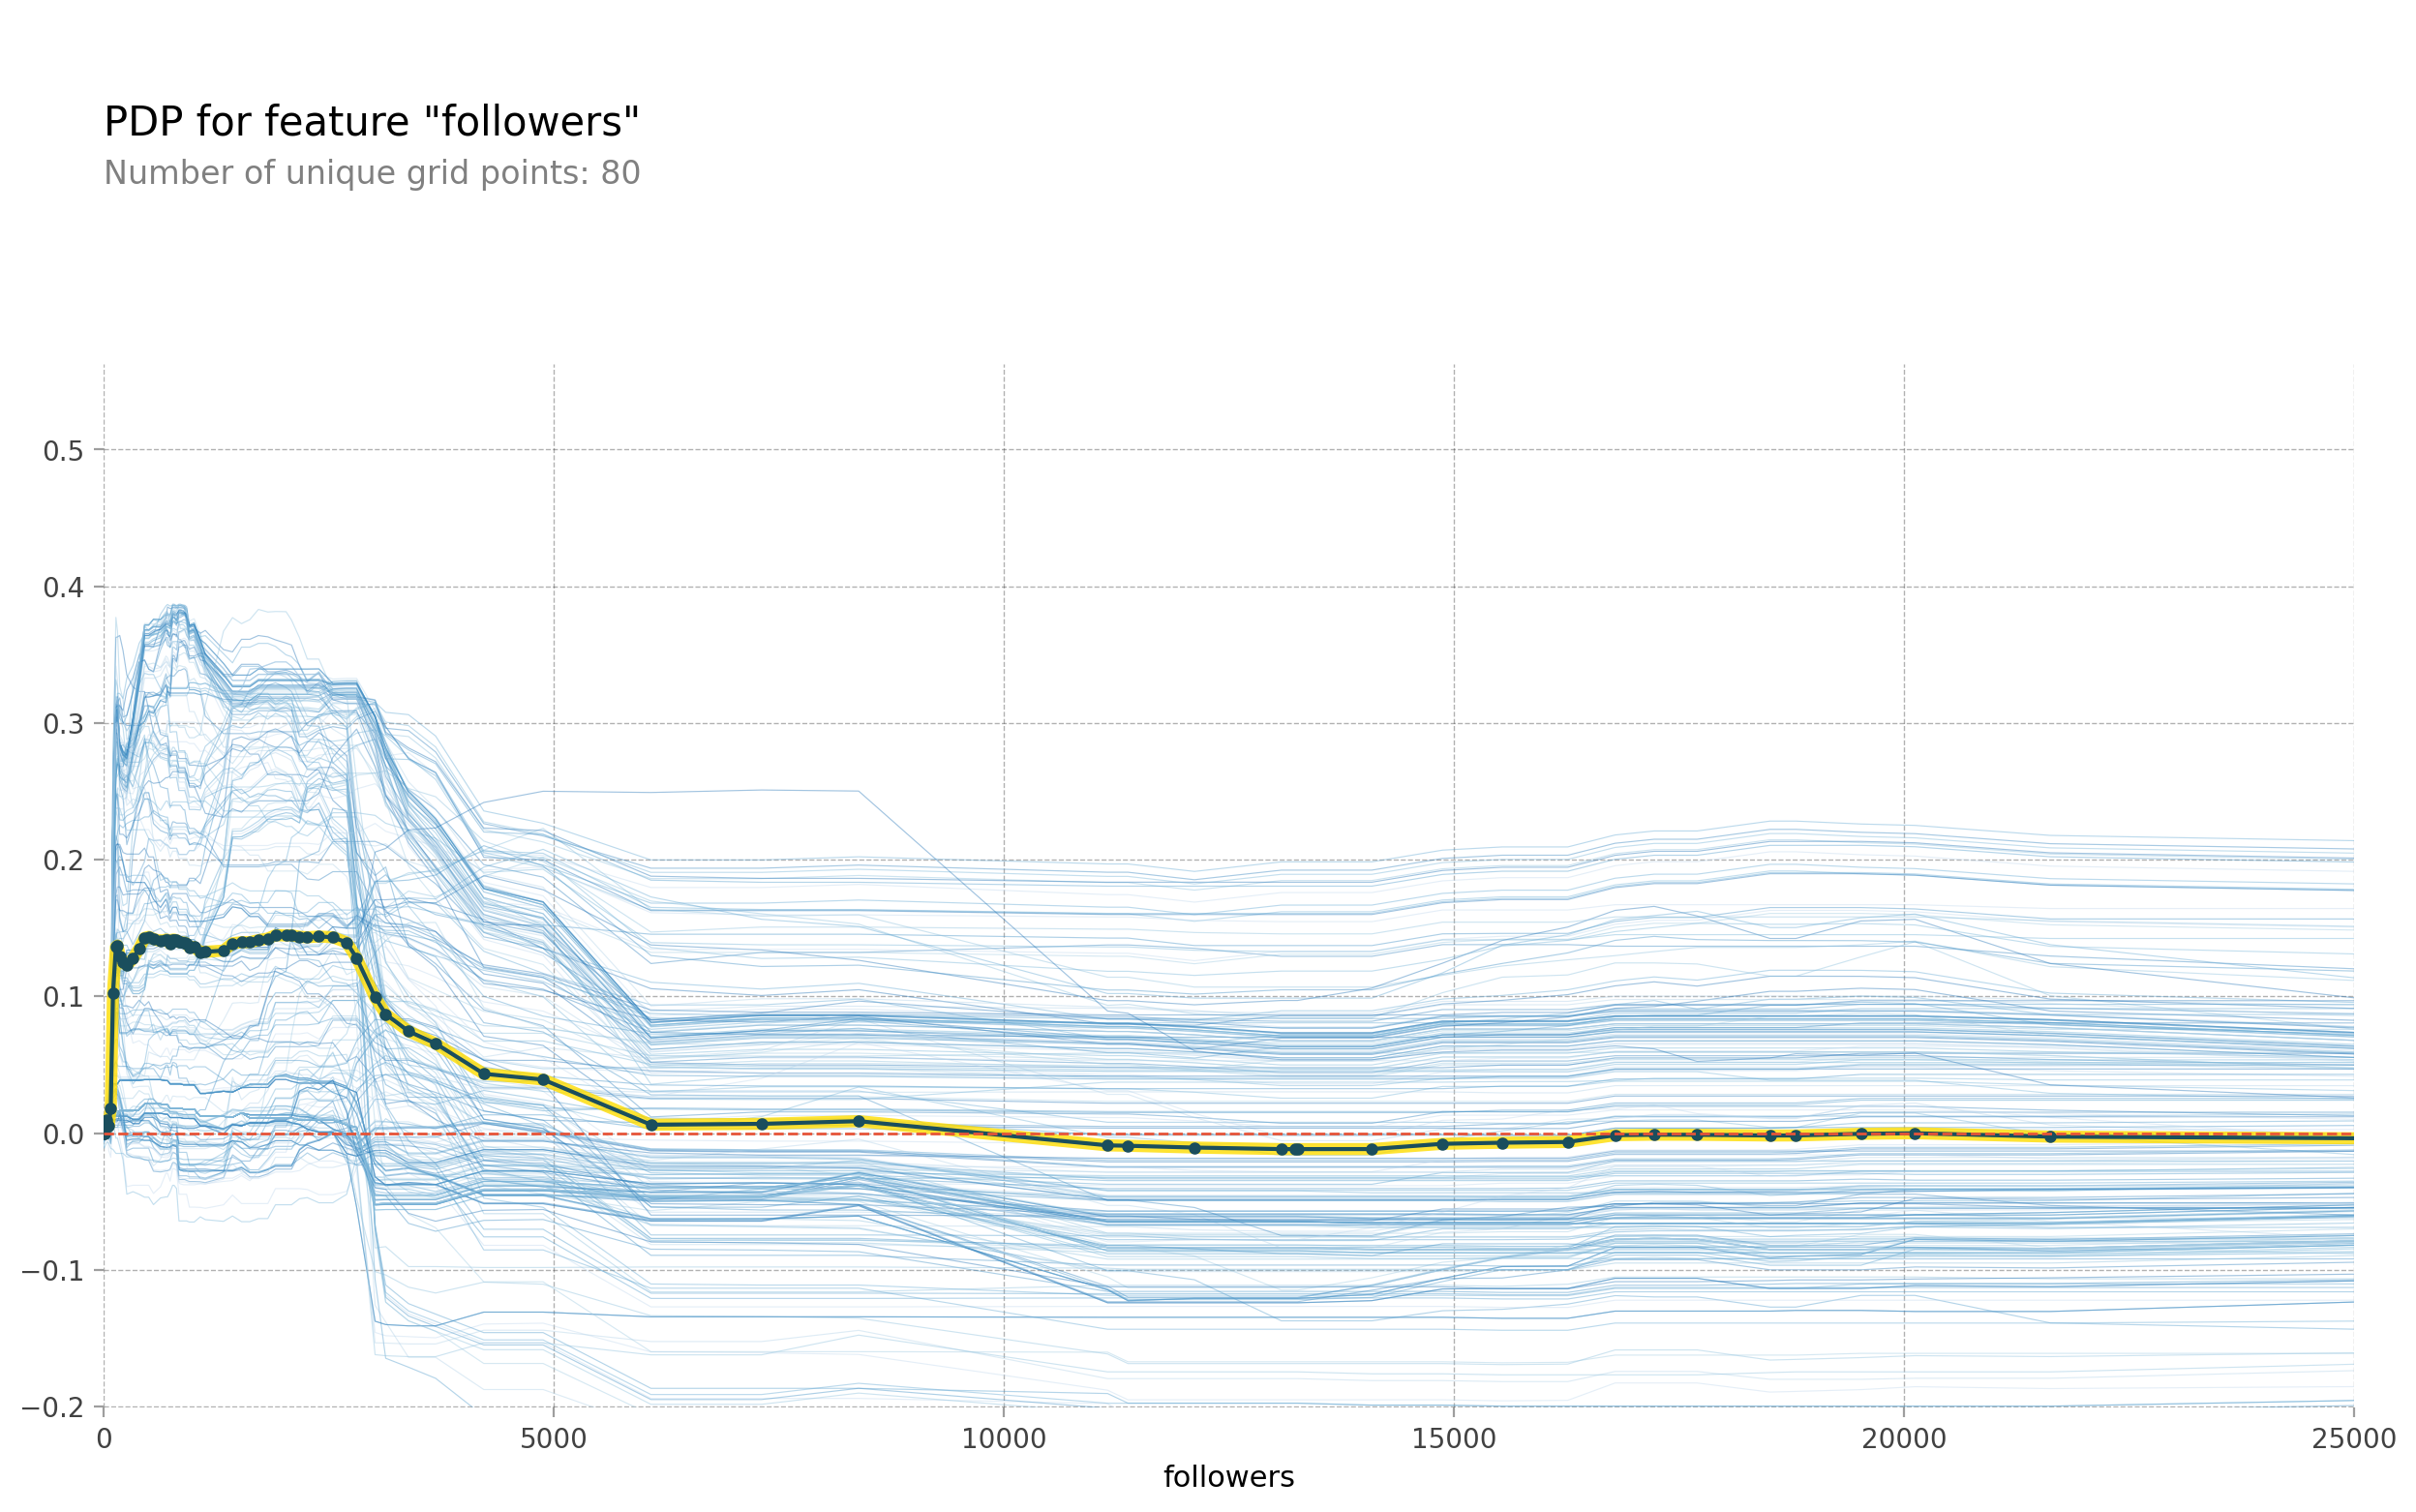

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.show()
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.1)
plt.xlim((0,25000));

# Make at least 1 Shapley force plot to explain an individual prediction.

In [75]:
encoder = pipeline.named_steps['ordinalencoder']
X_test_encoded = encoder.transform(X_test)

ValueError: ignored

In [62]:
row = X_test_encoded.iloc[[0]]
row

,region,publish_date,harvested_date,following,followers,updates,account_type,account_category
1,1.0,-1.0,-1.0,7,35,2213,-1.0,-1.0


In [63]:
y_test.iloc[[0]]

1    0
Name: retweet, dtype: int64

In [64]:
pipeline.predict(row)

array([0])

In [74]:
import shap
model = pipeline.named_steps['randomforestclassifier']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit'
)

SHAPError: ignored

## That's not going to work I think I need to do regression instead to practice this.

In [0]:
def wrangle(X):
  X=X
  X['region'] = X['region'].replace({np.NaN: 'Unknown'})

  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

target = 'updates'
features = ['retweet', 'following',	'followers']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [71]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

pipeline1 = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

pipeline1.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.7993066315946243


In [48]:
print("Train Accuracy:", gb.score(X_train, y_train))
print("Validation Accuracy:", gb.score(X_val, y_val))

Train Accuracy: 0.8382993308606458
Validation Accuracy: 0.7993066315946243


In [72]:
row = X_test.iloc[[0]]
row

,retweet,following,followers
1,0,7,35


In [50]:
y_test.iloc[[0]]

1    2213
Name: updates, dtype: int64

In [51]:
gb.predict(row)

array([1115.4753], dtype=float32)

In [73]:
import shap
model = pipeline1.named_steps['xgbregressor']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit'
)

# Stretch Goals

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


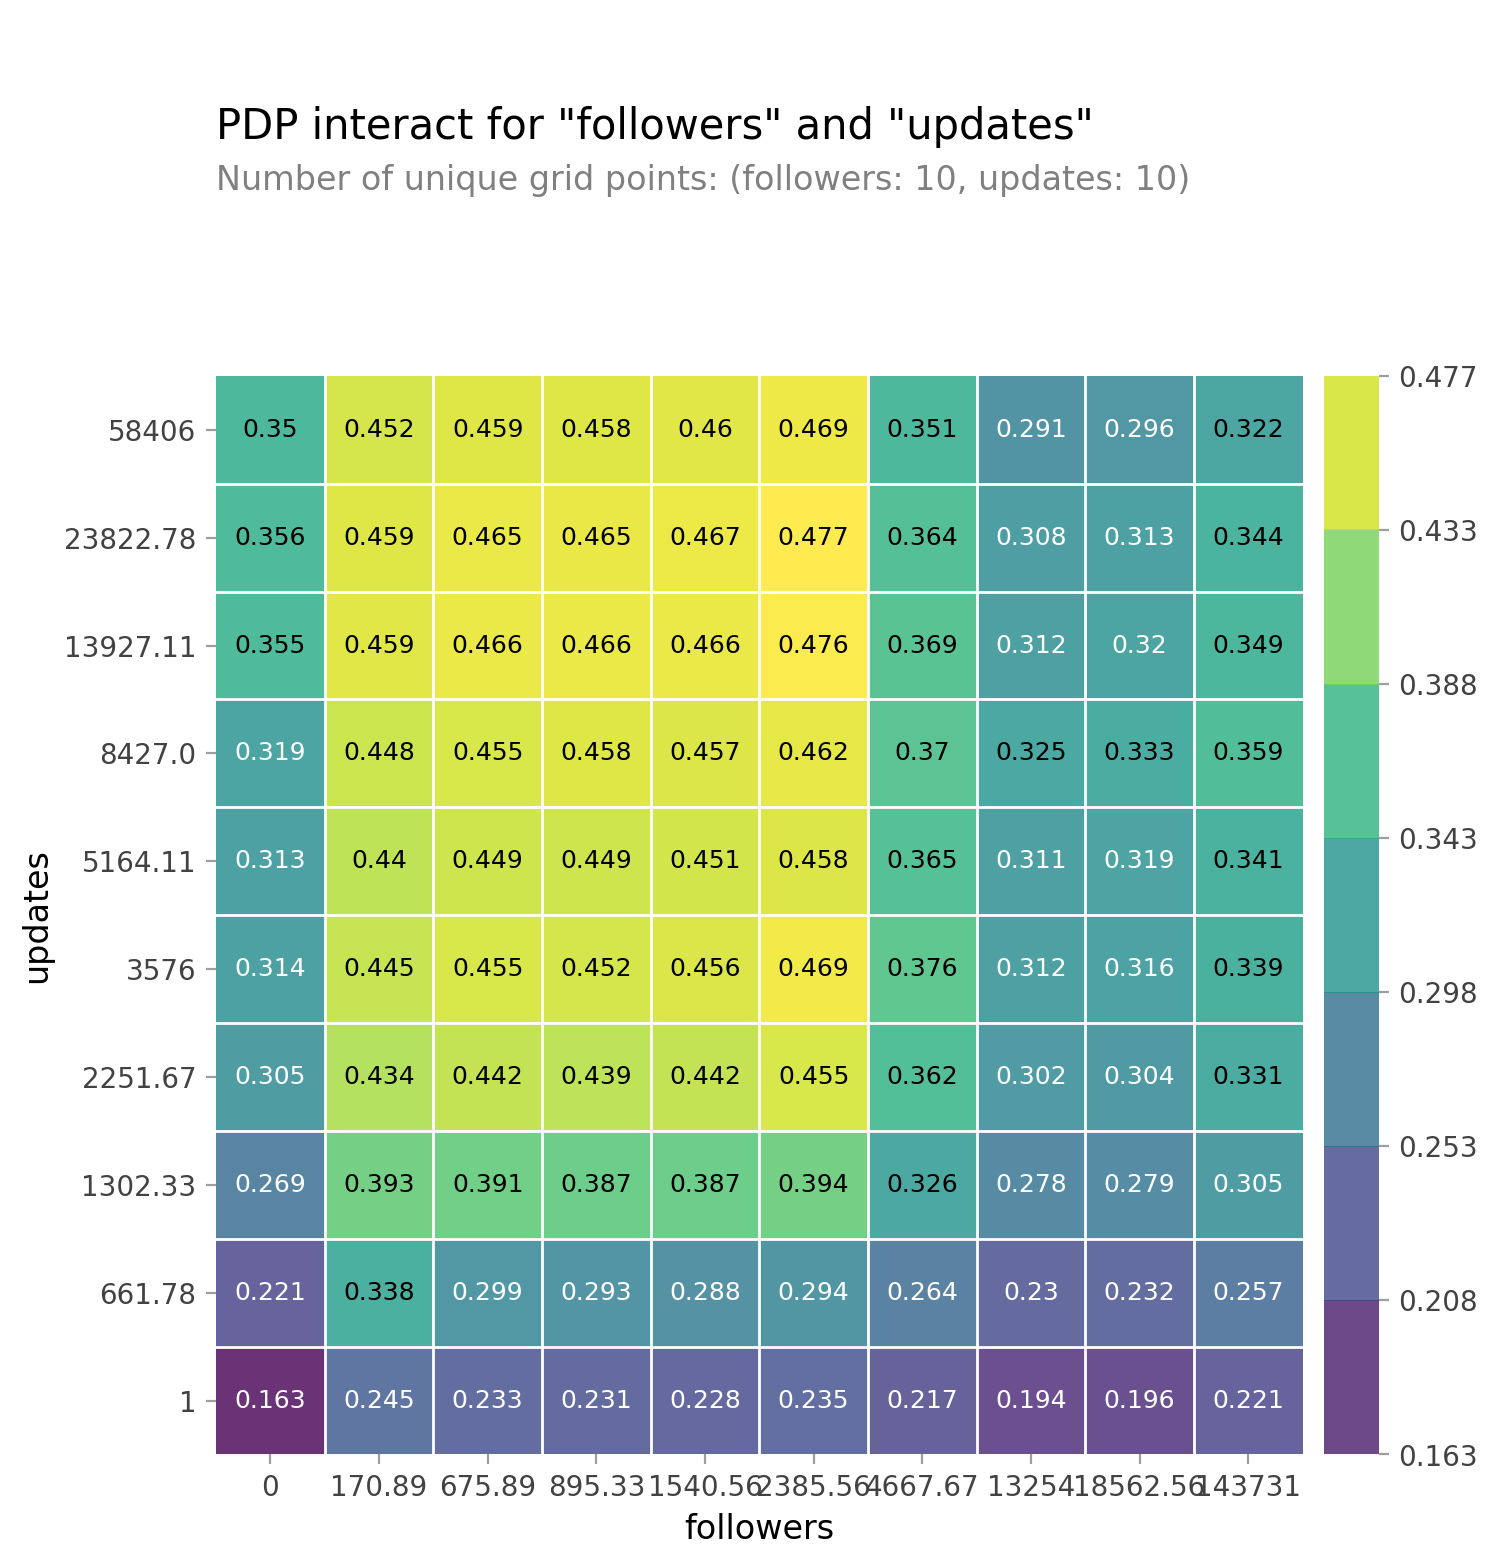

In [67]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['followers', 'updates']

interaction = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);